# The Extra-Galactic Pulsar Timing Array

### Chiara Mingarelli, mingarelli@gmail.com; Paul T. Baker, paultbaker@gmail.com

In [23]:
### drop box notes here https://paper.dropbox.com/doc/eXtra-Galactic-PTA-kUyKcb4RdI9LiU9Cl8mqh

In [9]:
from __future__ import division
from IPython.display import display, Math, Latex
import math
import numpy as np
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.mlab as ml
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text


%matplotlib inline
%config InlineBackend.figure_format = "retina"

### This code is largely duplicated from Chiara's phase.py code from 2012

# Physical constants for natural units c = G = 1



In [4]:
c=2.99792458*(10**8)
G=6.67428*(10**(-11))
s_mass=G*(1.98892*10**(30))/(c**3)

# common function shortcuts
log10 = np.log10
pi = np.pi
sqrt = np.sqrt

# Functions 

In [10]:
#converts solar mass to seconds
def solarMassToSec(m): return m*4.925e-6

def secToSolarMass(m):  return m/4.925e-6

#converts kpc to light seconds
def kpcToSec(d): return d*1.02927214e11

#converts kpc to light years
def kpcToYears(d): return d*3261.63626

#converts sec to yrs
def secToYears(t): return t*3.16887646e-8 

#converts yrs to sec
def yearsToSec(t): return t*31556926.

#calculates eta parameter for two masses
def calcEta(m_1, m_2): return (m_1*m_2)/((m_1+m_2)*(m_1+m_2))

#calculates chirp mass
def calcChirpMass(m_1,m_2): return pow((m_1*m_2)/((m_1+m_2)*(m_1+m_2)),3./5.)*(m_1+m_2)
	
#calculate the frequency diff from earth at a given time and observed earth frequency
def calcFreq(t, mchirp, fE, offset): 
	return (-(256./5.)*pi**(8./3.)*mchirp**(5./3.)*(t+offset)+fE**(-8./3.))**(-3./8.) -fE
	
#the newtonian expression for df/dt
def dfdt_newtonain(mchirp, f):
	return (96./5.)*pi**(8./3.)*mchirp**(5./3.)*f**(11./3.)

#calculates the time to coalesence if the time at the earth is 0
def calctc(fE, mchirp): return 5*(8*pi*fE)**(-8./3.)*mchirp**(-5./3.)

def calcBeta(m1, m2, eta, Lchi1, Lchi2):
	return (1./12.)*((113.*(m1/(m1+m2))**2. + 75.*eta)*Lchi1 + (113.*(m2/(m1+m2))**2. + 75.*eta)*Lchi2 )
	
def calcSigma(eta, chi1chi2, Lchi1, Lchi2):
	return (eta/48.)*(-247.*chi1chi2+721.*Lchi1*Lchi2)

def dfdt_2PN(f, t0, mchirp, eta,  beta, sigma):
	b0=1.
	b1=0.
	b2=-((743./336.)+(11./4.)*eta)*(pi*mchirp*f)**(2./3.)*eta**(-2./5.)
	b3=(4*pi-beta)*(pi*mchirp*f)**(3./3.)*eta**(-3./5.)
	b4=((34103./18144.)+(13661./2016.)*eta+(59./18.)*eta*eta+sigma)*(pi*mchirp*f)**(4./3.)*eta**(-4./5.)
	return (96./5.)*pi**(8./3.)*mchirp**(5./3.)*f**(11./3.)*(b0+b1+b2+b3+b4)

def calcFreq2PN(fE, t_array, mchirp, eta, beta, sigma):
	fp_PN_array=integrate.odeint(dfdt_2PN,fE,t_array,args=(mchirp,eta,beta,sigma))
	#print "freq diff= ",fp_PN_array[t_array.size-1] -fE - calcFreq(t_array[t_array.size-1], mchirp, fE, 0)
	return fp_PN_array
	
#the phase integrand
def phase_integrand_2PN(mchirp, eta, beta, sigma, fE, t_array):
	freq=np.empty(t_array.size)
	freq_ans=calcFreq2PN(fE, t_array, mchirp, eta, beta, sigma)
	size=freq.size
	for k in range(size):
		freq[k]=2*pi*(freq_ans[k]-fE)
		
	return freq

def calc_change_in_phase_2PN( mchirp, eta, beta, sigma, fE, t_array, t1, t2):
	ans=integrate.simps( phase_integrand_2PN(mchirp, eta, beta, sigma, fE, t_array), x=t_array)

	#ans= integrate.quad(phase_integrand_15PN, t1, t2, args=( mchirp, eta, beta, sigma, fE, t_array))
	#print "error on integeration=" , ans[1]
	return ans
	
def dfdt_15PN(f, t0, mchirp, eta,  beta, sigma):	
	b0=1.
	b1=0.
	b2=-((743./336.)+(11./4.)*eta)*(pi*mchirp*f)**(2./3.)*eta**(-2./5.)
	b3=(4*pi-beta)*(pi*mchirp*f)**(3./3.)*eta**(-3./5.)
	return (96./5.)*pi**(8./3.)*mchirp**(5./3.)*f**(11./3.)*(b0+b1+b2+b3)

def calcFreq15PN(fE, t_array, mchirp, eta, beta, sigma):
	fp_PN_array=integrate.odeint(dfdt_15PN,fE,t_array,args=(mchirp,eta,beta,sigma))
	#print "freq diff= ",fp_PN_array[t_array.size-1] -fE - calcFreq(t_array[t_array.size-1], mchirp, fE, 0)
	return fp_PN_array
	
#the phase integrand
def phase_integrand_15PN(mchirp, eta, beta, sigma, fE, t_array):
	freq=np.empty(t_array.size)
	freq_ans=calcFreq15PN(fE, t_array, mchirp, eta, beta, sigma)
	size=freq.size
	for k in range(size):
		freq[k]=2*pi*(freq_ans[k]-fE)
	return freq

def calc_change_in_phase_15PN( mchirp, eta, beta, sigma, fE, t_array, t1, t2):
	ans=integrate.simps( phase_integrand_15PN(mchirp, eta, beta, sigma, fE, t_array), x=t_array)
	#ans= integrate.quad(phase_integrand_15PN, t1, t2, args=( mchirp, eta, beta, sigma, fE, t_array))
	#print "error on integeration=" , ans[1]
	return ans
	
def dfdt_1PN(f, t0, mchirp, eta,  beta, sigma):	
	b0=1.
	b1=0.
	b2=-((743./336.)+(11./4.)*eta)*(pi*mchirp*f)**(2./3.)*eta**(-2./5.)
	return (96./5.)*pi**(8./3.)*mchirp**(5./3.)*f**(11./3.)*(b0+b1+b2)

def calcFreq1PN(fE, t_array, mchirp, eta, beta, sigma):
	fp_PN_array=integrate.odeint(dfdt_1PN,fE,t_array,args=(mchirp,eta,beta,sigma))
	#print "freq diff= ",fp_PN_array[t_array.size-1] -fE - calcFreq(t_array[t_array.size-1], mchirp, fE, 0)
	return fp_PN_array
	
#the phase integrand
def phase_integrand_1PN(mchirp, eta, beta, sigma, fE, t_array):
	freq=np.empty(t_array.size)
	freq_ans=calcFreq1PN(fE, t_array, mchirp, eta, beta, sigma)
	size=freq.size
	for k in range(size):
		freq[k]=2*pi*(freq_ans[k]-fE)
	return freq

def calc_change_in_phase_1PN( mchirp, eta, beta, sigma, fE, t_array, t1, t2):
	ans=integrate.simps( phase_integrand_1PN(mchirp, eta, beta, sigma, fE, t_array), x=t_array)
	#ans= integrate.quad(phase_integrand_15PN, t1, t2, args=( mchirp, eta, beta, sigma, fE, t_array))
	#print "error on integeration=" , ans[1]
	return ans
	
#the phase integrand
def phase_integrand(t, mchirp, fE, offset):
	return 2*pi*calcFreq(t,mchirp,fE, offset)

def calc_change_in_phase(mchirp, fE, t1, t2, offset):
	ans= integrate.quad(phase_integrand, t1, t2, args=(mchirp, fE, offset))
#	print "error on integeration=" , ans[1]
	return ans[0]	
	
def calcBeta(m1, m2, eta, Lchi1, Lchi2):
	return (1./12.)*((113.*(m1/(m1+m2))**2. + 75.*eta)*Lchi1 + (113.*(m2/(m1+m2))**2. + 75.*eta)*Lchi2 )
	
def calcSigma(eta, chi1chi2, Lchi1, Lchi2):
	return (eta/48.)*(-247.*chi1chi2+721.*Lchi1*Lchi2)


In [61]:
#Plotting preamble, adapted from Justin Ellis

In [51]:
fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 4,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

# Main Part of Code

In [11]:
m1 = solarMassToSec(1.0e9)
m2 = solarMassToSec(1.0e9)
fE = 1.0e-7
mchirp=calcChirpMass(m1,m2)
eta=calcEta(m1,m2)

chi1=1.
chi2=1.
cosLchi1=1.
cosLchi2=1.
coschi1chi2=1.
Lchi1=chi1*cosLchi1
Lchi2=chi1*cosLchi2
chi1chi2=chi1*chi2*coschi1chi2
beta= calcBeta(m1, m2, eta, Lchi1, Lchi2)
sigma = calcSigma(eta, chi1chi2, Lchi1, Lchi2)


t1=0. 	#The phase change is measured from this point
t2=	10. #years, the max time to calculate the phase change at 
lookback =-kpcToYears(1) #kpc -> years,  the min time to calculate the phase change at

#Number of points in time to calculate the frequency and time at
steps=1000
#Size of the time array. The number of points ode-int and simps rule use
t_size=100


In [12]:
# initialize arrays
time_array_yrs=np.empty(steps+1)	#full time range in years
time_array_sec=np.empty(steps+1)	#full time range in seconds
approx=np.empty(steps+1)			#the approximate phase change df/dt*t*t
exact=np.empty(steps+1)				#the exact newtonian phase change. Quad the analytic f(t)
exact_1PN_no_spin=np.empty(steps+1) #the exact 1PN non-spining phase change. simps rule on odeint df/dt=y(f,t)
exact_15PN_no_spin=np.empty(steps+1)#the exact 15PN non-spining phase change. simps rule on odeint df/dt=y(f,t)
exact_2PN_no_spin=np.empty(steps+1) #the exact 2PN non-spining phase change. simps rule on odeint df/dt=y(f,t)
exact_1PN_spin=np.empty(steps+1) #the exact 1PN non-spining phase change. simps rule on odeint df/dt=y(f,t)
exact_15PN_spin=np.empty(steps+1)#the exact 15PN non-spining phase change. simps rule on odeint df/dt=y(f,t)
exact_2PN_spin=np.empty(steps+1) #the exact 2PN non-spining phase change. simps rule on odeint df/dt=y(f,t)

f_approx=np.empty(steps+1) 		#the approximate frequency change, df/dt*t
f_exact=np.empty(steps+1)		#the exact newtonian frequency change, the analytic f(t)
f_exact_1PN=np.empty(steps+1)	#the exact 1PN non-spinning freq change. odeint on df/dt=y(f,t)
f_exact_15PN=np.empty(steps+1)	#the exact 15PN non-spinning freq change. odeint on df/dt=y(f,t)
f_exact_2PN=np.empty(steps+1)	#the exact 2PN non-spinning freq change. odeint on df/dt=y(f,t)

t_array=np.empty(t_size)		#the array which splits the current time period from 0 to t into t_size points
#the time range
total_time_diff=t2-lookback

for k in range(1,steps+1):
	time_array_yrs[k]=lookback+k*total_time_diff/(steps)
	time_array_sec[k]=yearsToSec(time_array_yrs[k])
	for j in range(t_size):
		t_array[j]=+j*(time_array_sec[k])/(t_size-1.)
	#print t_array
	approx[k]=(dfdt_newtonain(mchirp, fE)*time_array_sec[k]*time_array_sec[k])
	exact[k]=(calc_change_in_phase(mchirp, fE, t1, time_array_sec[k], 0)) 
	exact_1PN_no_spin[k]=calc_change_in_phase_1PN( mchirp, eta, 0, 0, fE, t_array, t1, t2)
	exact_15PN_no_spin[k]=calc_change_in_phase_15PN( mchirp, eta, 0, 0, fE, t_array, t1, t2)
	exact_2PN_no_spin[k]=calc_change_in_phase_2PN( mchirp, eta, 0, 0, fE, t_array, t1, t2)
	exact_1PN_spin[k]=calc_change_in_phase_1PN( mchirp, eta, beta, sigma, fE, t_array, t1, t2)
	exact_15PN_spin[k]=calc_change_in_phase_15PN( mchirp, eta, beta, sigma, fE, t_array, t1, t2)
	exact_2PN_spin[k]=calc_change_in_phase_2PN( mchirp, eta, beta, sigma, fE, t_array, t1, t2)
	f_approx[k]=dfdt_newtonain(mchirp, fE)*time_array_sec[k]
	f_exact[k] = calcFreq(time_array_sec[k], mchirp, fE, 0)
	f_exact_2PN[k] =calcFreq2PN(fE, t_array, mchirp, eta, 0, 0)[t_size-1]-fE
	f_exact_15PN[k] =calcFreq15PN(fE, t_array, mchirp, eta, 0, 0)[t_size-1]-fE
	f_exact_1PN[k] =calcFreq1PN(fE, t_array, mchirp, eta, 0, 0)[t_size-1]-fE



In [58]:
	print "M1 : M2 = ", secToSolarMass(m1), " : ",secToSolarMass(m2),"\n"
	print "f_earth = " , fE
	print "Newtonian:"
	print "		phase at +10years - phase at earth = ", exact[steps]
	print "2PN no spin:"
	print "		phase at +10years - phase at earth = " , exact_2PN_no_spin[steps]
	print "2PN max spin:"
	print "		phase at +10years - phase at earth = " , exact_2PN_spin[steps],"\n"

M1 : M2 =  1000000000.0  :  1000000000.0 

f_earth =  1e-07
Newtonian:
		phase at +10years - phase at earth =  3.224787001
2PN no spin:
		phase at +10years - phase at earth =  3.15743488418
2PN max spin:
		phase at +10years - phase at earth =  3.07896799121 



# Plotting change in phase


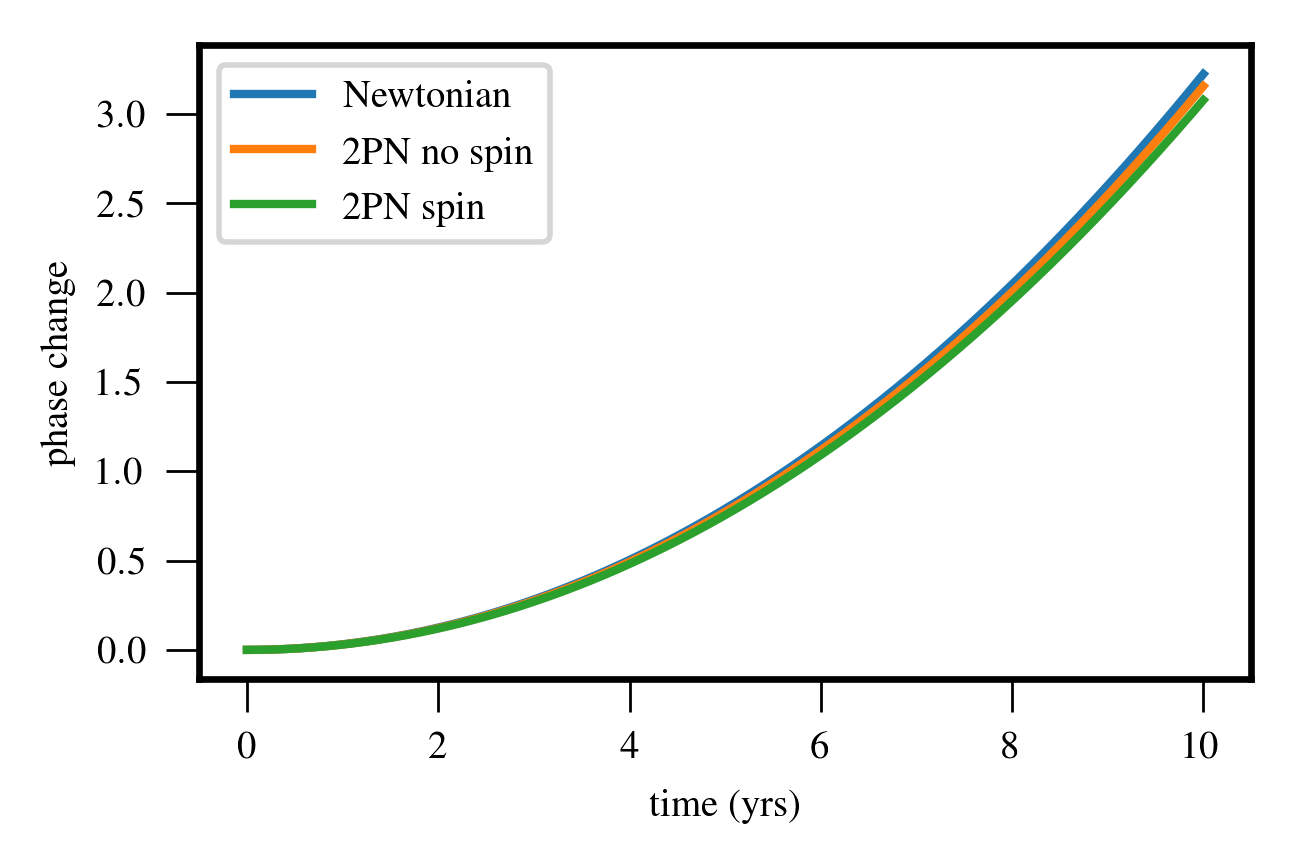

In [55]:
# Phase change over 10 years, so an Earth-term only argument
plt.figure(1)
#plt.plot(time_array_yrs, approx, ",", label="approx")
plt.plot(time_array_yrs, exact, label="Newtonian")
plt.plot(time_array_yrs, exact_2PN_no_spin, label=" 2PN no spin")
#plt.plot(time_array_yrs, exact_15PN_no_spin, ",", label="exact 1.5PN no spin")
#plt.plot(time_array_yrs, exact_1PN_no_spin, ",", label="exact 1PN no spin")
plt.plot(time_array_yrs, exact_2PN_spin, label=" 2PN spin")
#plt.plot(time_array_yrs, exact_15PN_spin, ",", label="exact 1.5PN spin")
#plt.plot(time_array_yrs, exact_1PN_spin, ",", label="exact 1PN spin")
plt.legend(loc="upper left")
plt.xlabel("time (yrs)")
plt.ylabel("phase change")
plt.savefig("../figures/phase.pdf")

In [20]:
print "M1 : M2 = ", secToSolarMass(m1), " : ",secToSolarMass(m2),"\n"
print "f_earth = " , fE
print "Newtonian:"
print "		phase at +10years - phase at earth = ", exact[steps]
print "2PN no spin:"
print "		phase at +10years - phase at earth = " , exact_2PN_no_spin[steps]
print "2PN max spin:"
print "		phase at +10years - phase at earth = " , exact_2PN_spin[steps],"\n"

M1 : M2 =  1000000000.0  :  1000000000.0 

f_earth =  1e-07
Newtonian:
		phase at +10years - phase at earth =  3.224787001
2PN no spin:
		phase at +10years - phase at earth =  3.15743488418
2PN max spin:
		phase at +10years - phase at earth =  3.07896799121 



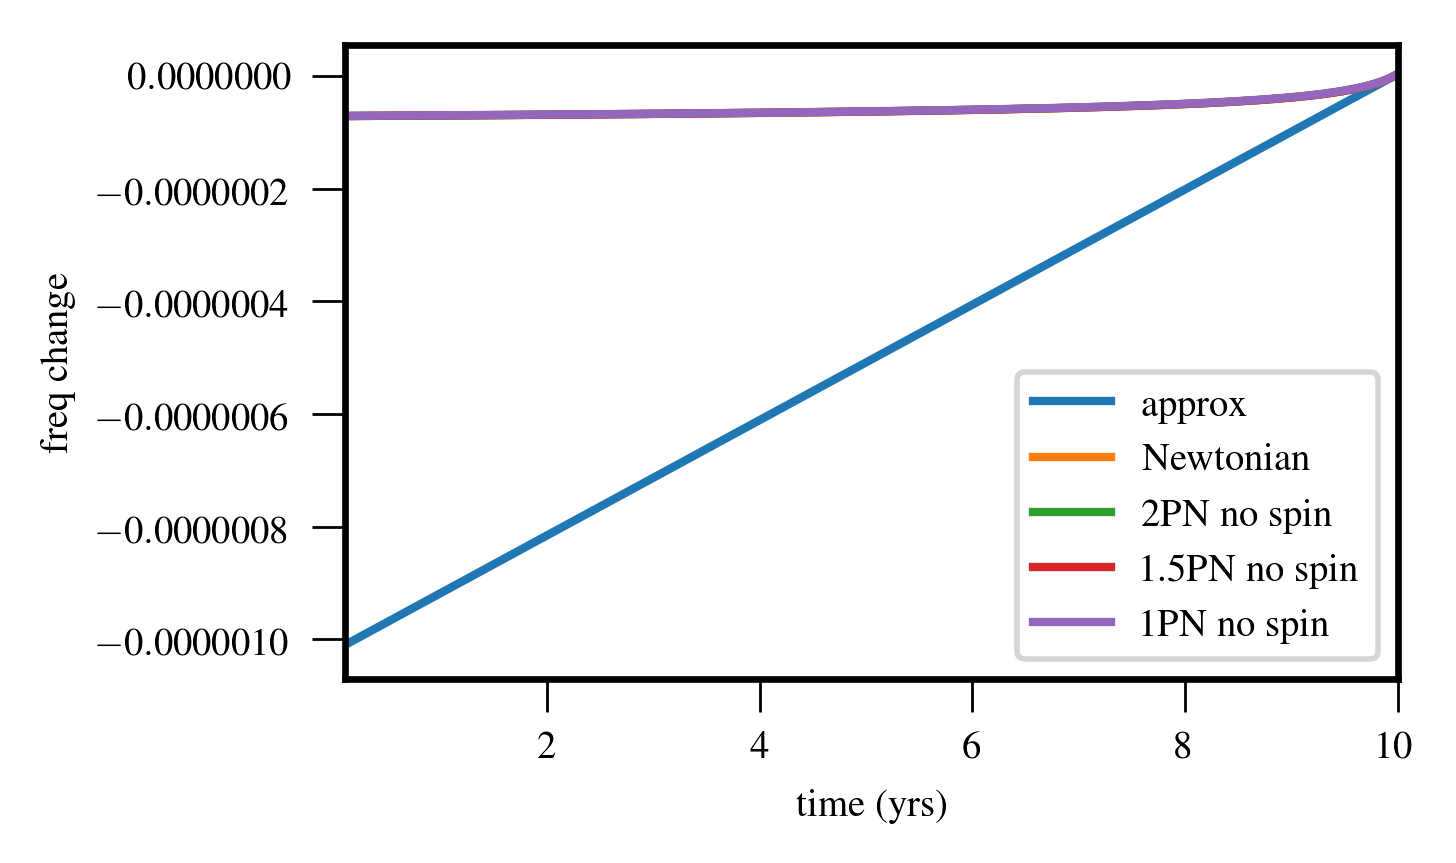

In [56]:
plt.plot(time_array_yrs, f_approx, label="approx")
plt.plot(time_array_yrs, f_exact, label="Newtonian")
plt.plot(time_array_yrs, f_exact_2PN, label="2PN no spin")
plt.plot(time_array_yrs, f_exact_15PN, label="1.5PN no spin")
plt.plot(time_array_yrs, f_exact_1PN, label="1PN no spin")
plt.legend(loc="lower right")
plt.xlim(0.1,10)
plt.xlabel("time (yrs)")
plt.ylabel("freq change")
plt.savefig("../figures/freq_test.pdf")

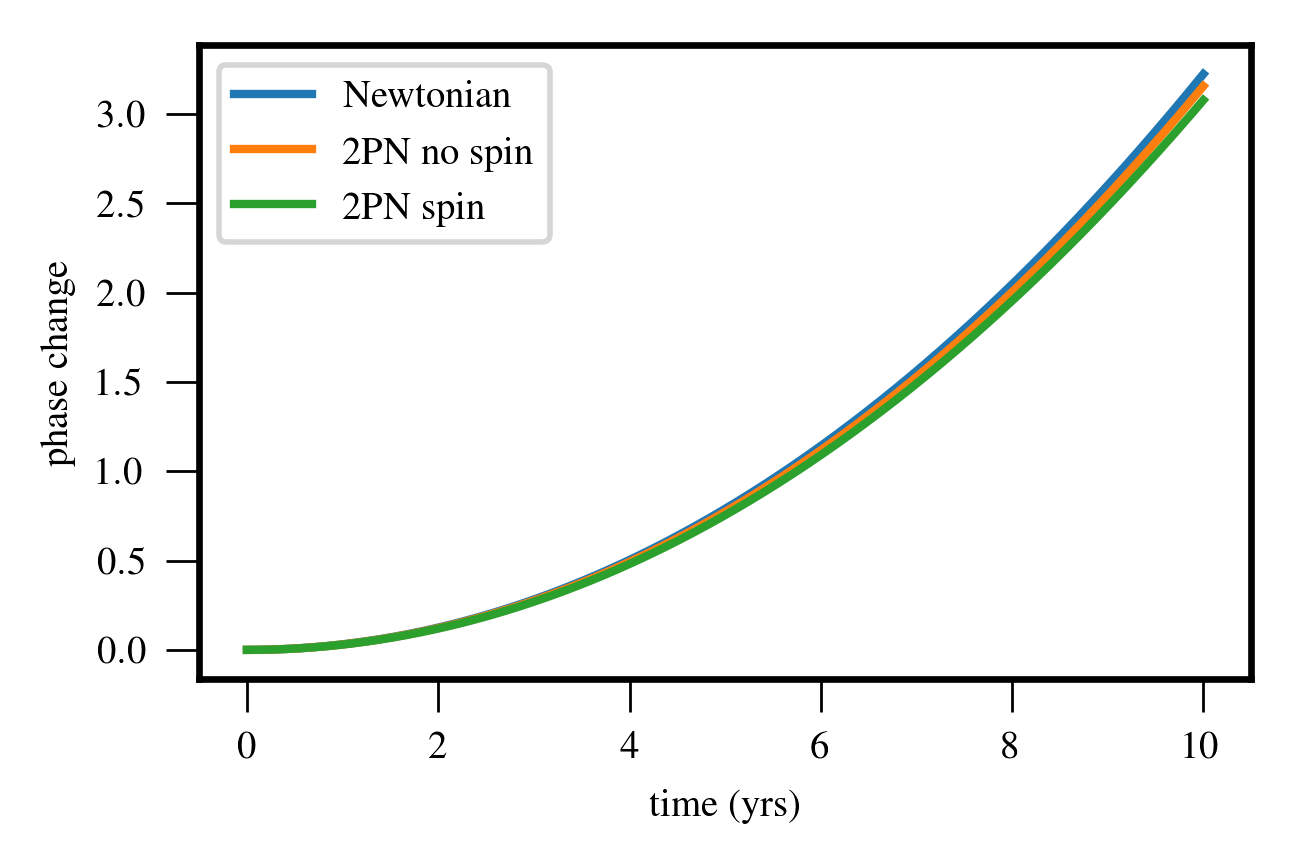

In [57]:
t1=0. 	#The phase change is measured from this point
t2=	10. #years, the max time to calculate the phase change at 
lookback =0 #kpc -> years,  the min time to calculate the phase change at
#Number of points in time to calculate the frequency and time at
steps=1000
#Size of time array. The number of points ode-int and simps rule use
t_size=100

#set up various arrays
time_array_yrs=np.empty(steps+1)	#full time range in years
time_array_sec=np.empty(steps+1)	#full time range in seconds
exact=np.empty(steps+1)				#the exact newtonian phase change. Quad the analytic f(t)
exact_2PN_no_spin=np.empty(steps+1) #the exact 2PN non-spining phase change. simps rule on odeint df/dt=y(f,t)
exact_2PN_spin=np.empty(steps+1) #the exact 2PN non-spining phase change. simps rule on odeint df/dt=y(f,t)

#the time range
total_time_diff=t2-lookback

for k in range(1,steps+1):
	time_array_yrs[k]=lookback+k*total_time_diff/(steps)
	time_array_sec[k]=yearsToSec(time_array_yrs[k])
	for j in range(t_size):
		t_array[j]=+j*(time_array_sec[k])/(t_size-1.)
		#print t_array
	exact[k]=(calc_change_in_phase(mchirp, fE, t1, time_array_sec[k], 0)) 
	exact_2PN_no_spin[k]=calc_change_in_phase_2PN( mchirp, eta, 0, 0, fE, t_array, t1, t2)
	exact_2PN_spin[k]=calc_change_in_phase_2PN( mchirp, eta, beta, sigma, fE, t_array, t1, t2)

plt.figure(3)
plt.plot(time_array_yrs, exact, label="Newtonian")
plt.plot(time_array_yrs, exact_2PN_no_spin,label=" 2PN no spin")
plt.plot(time_array_yrs, exact_2PN_spin, label=" 2PN spin")
plt.legend(loc="upper left")
plt.xlabel("time (yrs)")
plt.ylabel("phase change")
#plt.grid(True)
plt.savefig("../figures/phase_10yrs.pdf")

# Looking back with the pulsar term (kpc scale, galactic)

In [33]:
t1=0. 	#The phase change is measured from this point for the newtonian case
t2=	-kpcToYears(1)+10. #years, the max time to calculate the phase change at 
lookback =-kpcToYears(1) #kpc -> years,  the min time to calculate the phase change at
#Number of points in time to calculate the frequency and time at
steps=1000
#Size of the time array. The number of points ode-int and simps rule use
t_size=100

#set up various arrays
time_array_yrs=np.empty(steps+1)	#full time range in years
time_array_sec=np.empty(steps+1)	#full time range in seconds
exact=np.empty(steps+1)				#the exact newtonian phase change. Quad the analytic f(t)
exact_2PN_no_spin=np.empty(steps+1) #the exact 2PN non-spining phase change. simps rule on odeint df/dt=y(f,t)
exact_2PN_spin=np.empty(steps+1) #the exact 2PN non-spining phase change. simps rule on odeint df/dt=y(f,t)

#the time range
total_time_diff=t2-lookback
		
for k in range(1,steps+1):
	time_array_yrs[k]=lookback+k*total_time_diff/(steps)
	time_array_sec[k]=yearsToSec(time_array_yrs[k])
	for j in range(t_size):
		t_array[j]=j*(time_array_sec[k])/(t_size-1.)
	#print t_array
	exact[k]=(calc_change_in_phase(mchirp, fE, t1, time_array_sec[k], 0)) 
	exact_2PN_no_spin[k]=calc_change_in_phase_2PN( mchirp, eta, 0, 0, fE, t_array, t1, t2)
	exact_2PN_spin[k]=calc_change_in_phase_2PN( mchirp, eta, beta, sigma, fE, t_array, t1, t2)

In [34]:
print "f_earth = " , fE
print "Newtonian:"
print "		phase at 1kpc - phase 1kpc-10 = ", exact[steps] - exact[1]
print "2PN no spin:"
print "		phase at 1kpc - phase 1kpc-10 = " , exact_2PN_no_spin[steps] - exact_2PN_no_spin[1] 
print "2PN max spin:"
print "		phase at 1kpc - phase 1kpc-10 = " , exact_2PN_spin[steps] - exact_2PN_spin[1],"\n"


f_earth =  1e-07
Newtonian:
		phase at 1kpc - phase 1kpc-10 =  -141.423107926
2PN no spin:
		phase at 1kpc - phase 1kpc-10 =  -141.27579235
2PN max spin:
		phase at 1kpc - phase 1kpc-10 =  -141.065615168 



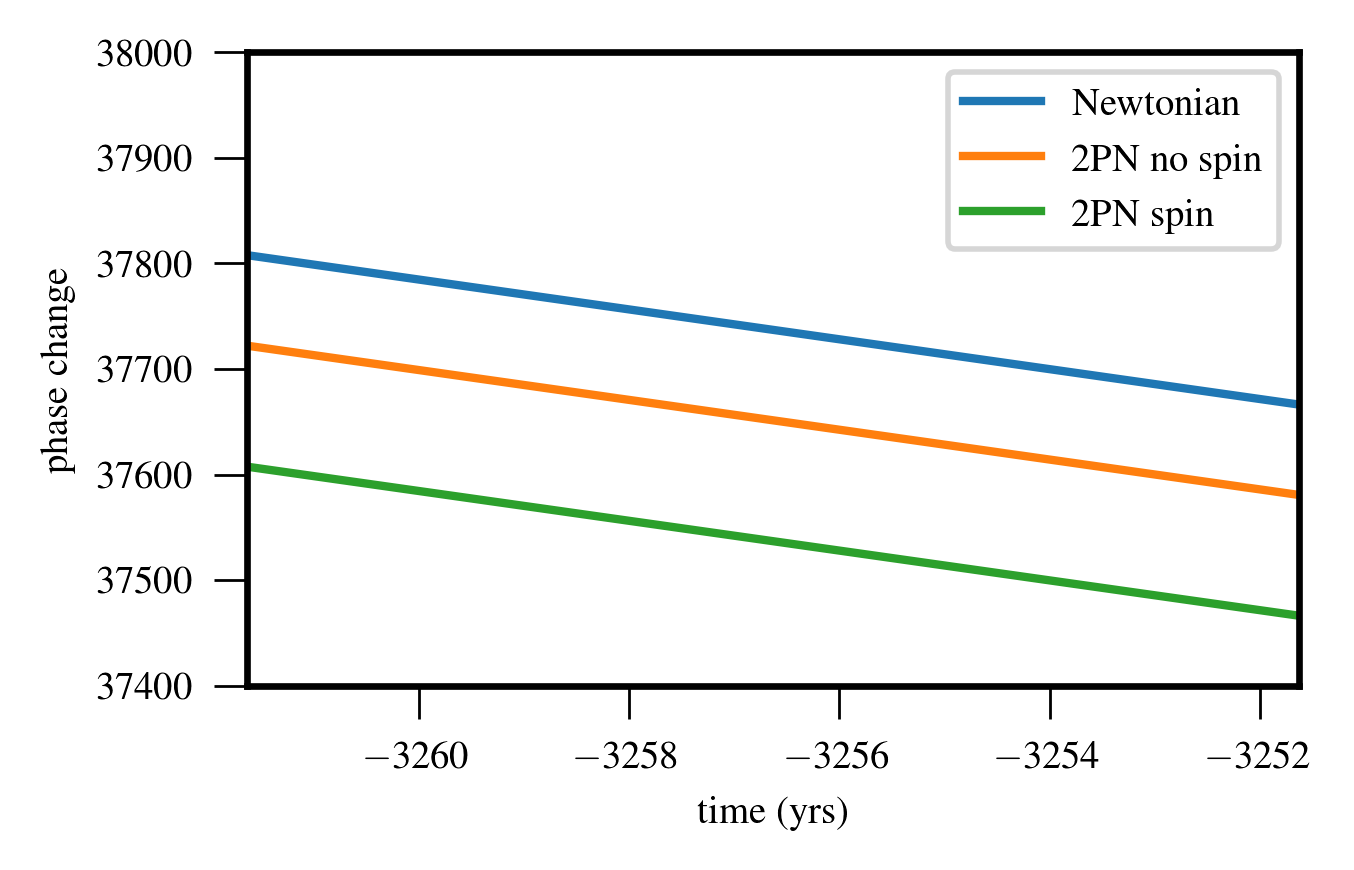

In [52]:
plt.plot(time_array_yrs[1:], exact[1:], label="Newtonian")
plt.plot(time_array_yrs[1:], exact_2PN_no_spin[1:], label=" 2PN no spin")
plt.plot(time_array_yrs[1:], exact_2PN_spin[1:], label=" 2PN spin")
plt.legend(loc="upper right")
plt.xlabel("time (yrs)")
plt.ylabel("phase change")
plt.xlim(lookback, t2)
plt.ylim(37400,38000)
#plt.savefig("../figures/phase_10yrs_1kpc.pdf")

# Individual pN Contributions

orbital velocity (v/c) 0.145723200512
fdot and deltaF at NW 9.90910922181e-18 0.952265396216 315.373916166
fdot and deltaF at 1PN 6.09974524309e-19 0.0586185517861 19.4134558603
fdot and deltaF at 1.5 (no spin) PN 3.85328012667e-19 0.0370300220173 12.2637062165
fdot and deltaF at 1.5 SO (in unit of beta) PN -3.06634289638e-20 -0.00294675552342 -0.975914732489
fdot and deltaF at 2PN SS (in unit of sigma) PN 4.46837300728e-21 0.000429410645999 0.142213418245
